<a href="https://colab.research.google.com/github/larasauser/master/blob/main/nspi_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NSPI 2

In [1]:
!pip install rasterio
!pip install numpy
!pip install opencv-python
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 45.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import rasterio
from rasterio.plot import show
import cv2
import tqdm
from math import sqrt
from tqdm import tqdm

In [3]:
def compute_rmsd(p1, p2):
    return np.sqrt(np.nanmean(p1-p2)**2)

In [4]:
def select_similar_pixels(input_patch, target_patch, gap_mask, stds, m, max_window):
  h,w,b = input_patch.shape
  x_c,y_c = h//2,w//2
  target_pixel = input_patch[x_c,y_c]

  if np.isnan(target_pixel).any():
        return [], []

  similar_pixels = []
  distances = []

  for i in range(h):
    for j in range(w):
      if gap_mask[i,j]:
        continue

      candidate = input_patch[i,j]

      if np.isnan(candidate).any():
        continue
      rmsd = np.sqrt(np.mean((candidate - target_pixel) ** 2))
      threshold = np.sum([2*stds[k]/m for k in range(b)])/b
      if rmsd <= threshold:
          similar_pixels.append(((i,j),candidate))
          distances.append(np.linalg.norm([i-x_c, j-y_c]))
  return similar_pixels, distances

In [5]:
def predict_pixel_value(similar_pixels, distances, input_patch, target_patch, stds, m, max_window, input_central, target_central):
  if len(similar_pixels)==0:
    return None #use histogram matching if no similar pixel available

  rmsds = [compute_rmsd(input_patch[i,j],input_central) for (i,j),_ in similar_pixels]
  cds = [r*d for r,d in zip(rmsds,distances)]
  weights = 1/(np.array(cds)+1e-6)
  weights /=weights.sum()

  #Prediction L1 (eq7)
  L1 = np.zeros_like(input_central)
  for w, ((i,j),_) in zip(weights, similar_pixels):
    L1 += w*target_patch[i,j]

  #Prediction L2 (eq8)
  delta = np.zeros_like(input_central)
  for w, ((i,j),_) in zip(weights, similar_pixels):
    delta += w * (target_patch[i,j]-input_patch[i,j])
  L2 = input_central + delta

  #Final ponderation T1,T2 (eq11)
  R1 = np.mean([compute_rmsd(input_patch[i,j], input_central)for (i,j),_ in similar_pixels])
  R2 = np.mean([compute_rmsd(target_patch[i,j],input_patch[i,j])for (i,j),_ in similar_pixels])

  T1 = 1/R1 if R1 != 0 else 1e6
  T2 = 1/R2 if R2 != 0 else 1e6
  T_sum = T1 + T2
  T1, T2 = T1/T_sum, T2/T_sum

  return T1*L1 + T2*L2

In [39]:
def filled_gaps_nspi(target, input_shape, gap_mask, m=20, max_window =151):
  filled = target.copy()
  h,w,b = target.shape
  pad = max_window//2
  padded_target = np.pad(target, ((pad,pad),(pad,pad),(0,0)),mode='reflect')
  padded_input = np.pad(input_image,((pad,pad),(pad,pad),(0,0)),mode='reflect')
  padded_mask = np.pad(gap_mask,((pad,pad),(pad,pad)),mode='constant',constant_values=1)

  stds = np.nanstd(input_image[~gap_mask],axis=0)

  for y in tqdm(range(pad,pad+h)):
    for x in range(pad,pad+w):
      if not gap_mask[y-pad,x-pad]:
        continue

      for window in range(26, max_window +2, 4):
        r = window//2
        input_patch = padded_input[y-r:y+r+1, x-r:x+r+1]
        target_patch = padded_target[y-r:y+r+1, x-r:x+r+1]
        mask_patch = padded_mask[y-r:y+r+1, x-r:x+r+1]

        similar_pixels, distances = select_similar_pixels(
            input_patch, target_patch, mask_patch, stds, m, max_window
        )

        if len(similar_pixels) >= m or window == max_window:
          val = predict_pixel_value(similar_pixels, distances, input_patch, target_patch,stds,m,max_window,
                                    input_patch[r,r], target_patch[r,r])
          if val is not None:
            filled[y-pad,x-pad] = val
          break

  return filled


Application

In [7]:
#Drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
input_path = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/NDVI_2017-08-26.tif'
target_path = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes/NDVI_2017-08-26.tif'


In [55]:
import rasterio
import numpy as np

with rasterio.open(input_path) as src:
  input_image=src.read().transpose(1,2,0).astype(np.float32)
  input_profile = src.profile

with rasterio.open(target_path) as src:
  target_image = src.read().transpose(1,2,0).astype(np.float32)
  target_profile = src.profile

In [56]:
count = np.sum(target_image == -9999)
print("Occurrences de -9999 :", count)


Occurrences de -9999 : 8264


In [57]:
target_image[target_image == -9999] = np.nan

In [58]:
np.isnan(target_image).any()

np.True_

In [59]:
gap_mask = np.isnan(target_image[:,:,0])

In [60]:
filled_img = filled_gaps_nspi(target_image, input_image, gap_mask, m=20, max_window = 76)

100%|██████████| 347/347 [06:06<00:00,  1.06s/it]


In [61]:
import matplotlib.pyplot as plt
import numpy as np

def show_comparison(input_image, target_image, filled_img, band=0):
    """
    Affiche les images input / target / remplie NSPI pour une bande donnée,
    avec une échelle de couleur fixée entre -1 et 1 (NDVI typique).
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    vmin, vmax = -1, 1  # Échelle fixe NDVI

    titles = ['Input (référence)', 'Target avec trous', 'Image remplie (NSPI)']
    images = [input_image, target_image, filled_img]

    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img[:, :, band], cmap='RdYlGn', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


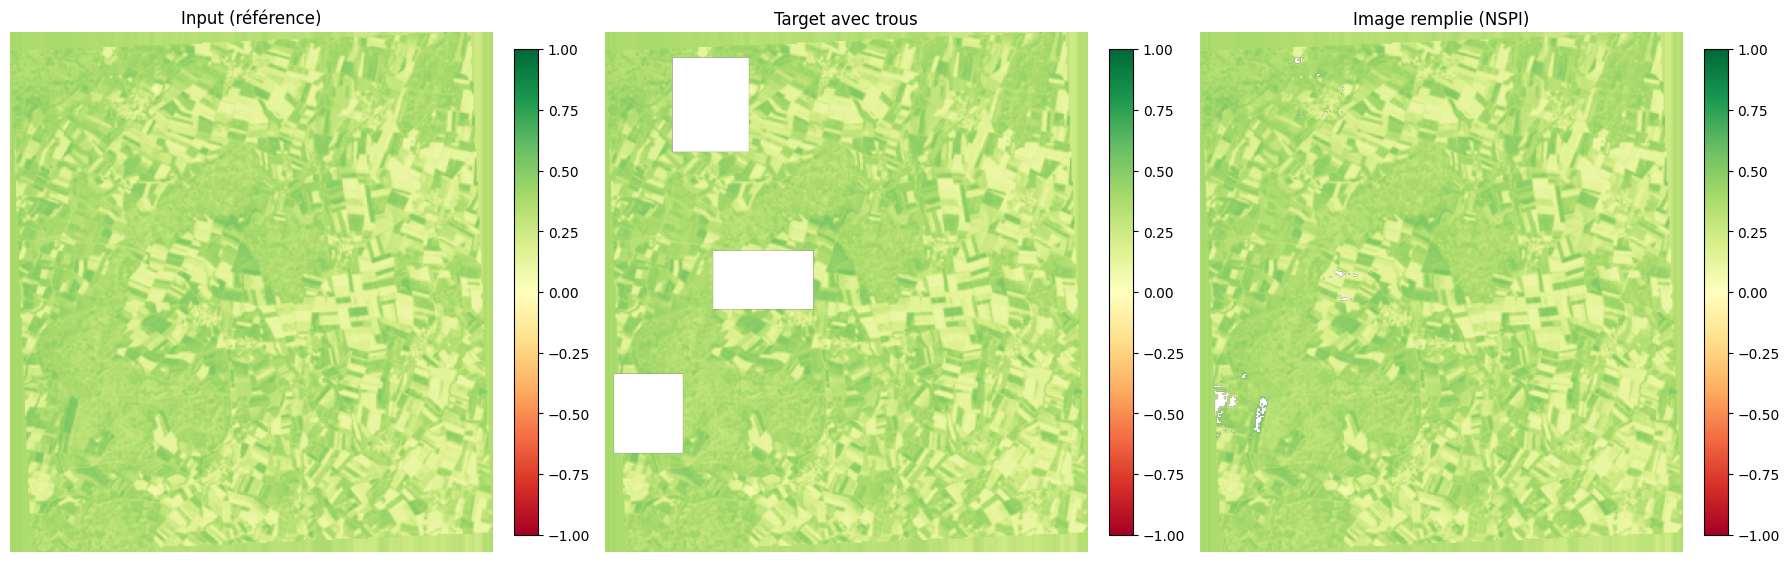

In [62]:
show_comparison(input_image, target_image, filled_img, band=0)

Metrics (old)

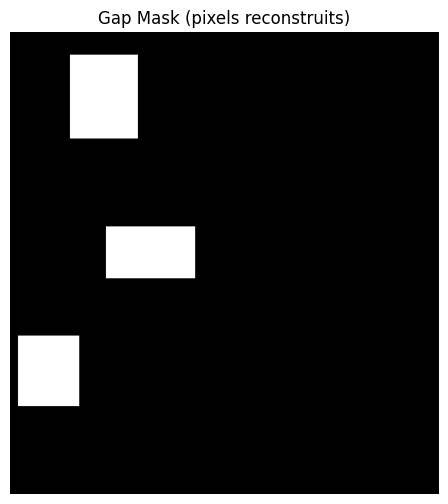

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.title("Gap Mask (pixels reconstruits)")
plt.imshow(gap_mask, cmap='gray')
plt.axis('off')  # pour enlever les axes, optionnel
plt.show()


In [51]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Extraire uniquement les pixels reconstruits
input_pixels = input_image[gap_mask]
filled_pixels = filled_img[gap_mask]

# RMSE
rmse = np.sqrt(mean_squared_error(input_pixels, filled_pixels))

# R-squared
r2 = r2_score(input_pixels, filled_pixels)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")


ValueError: Input contains NaN.

In [19]:
from skimage.metrics import structural_similarity as ssim

# SSIM entre les deux images sur la zone reconstruite
# On doit extraire la sous-image correspondant aux pixels gap_mask pour SSIM.
# Mais SSIM s'applique en général sur une image 2D, donc on peut appliquer un masque

# Créons des images où les pixels hors gap_mask sont mis à 0 pour éviter d'influencer la comparaison

input_img = np.squeeze(input_image)  # (757, 788)
filled_img = np.squeeze(filled_img)  # (757, 788)

input_masked = np.where(gap_mask, input_img, 0)
filled_masked = np.where(gap_mask, filled_img, 0)

ssim_index, _ = ssim(input_masked, filled_masked, full=True, data_range=2)

print(f"SSIM (sur pixels reconstruits): {ssim_index}")


SSIM (sur pixels reconstruits): 1.0000000004979215


In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que input_img, filled_img, gap_mask soient déjà définis et bien dimensionnés

# Calcul de la différence (absolue)
diff = np.abs(input_img - filled_img)

# Masquer les pixels hors gap_mask (mettre à NaN ou 0)
diff_masked = np.where(gap_mask, diff, np.nan)  # NaN pour ne rien afficher hors zone reconstruite

plt.figure(figsize=(6,6))
plt.title("Différence absolue sur pixels reconstruits")
im = plt.imshow(diff_masked, cmap='inferno')  # colormap pour bien voir les différences
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.axis('off')
plt.show()


ValueError: operands could not be broadcast together with shapes (757,788) (347,322) 

Export

In [ ]:
import os
from skimage.io import imsave

In [ ]:
output_dir = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_holes/filled_nspi2'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
filename = "NDVI_2023-08-20.tif"  # ou .png selon ton fichier
output_path = os.path.join(output_dir, filename)


In [ ]:
imsave(output_path, filled_img)
print(f"Image saved at: {output_path}")

Image saved at: /content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_holes/filled_nspi2/NDVI_2023-08-20.tif


Metrics (NEW)


In [22]:
pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [65]:
filled_img = np.squeeze(filled_img)
input_img = np.squeeze(input_img)

In [72]:
import numpy as np
import torch
import pandas as pd
from piq import multi_scale_ssim
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_nspi_metrics(input_image, filled_img, gap_mask, image_name):
    """
    Evaluates NSPI reconstruction quality using several metrics.

    Parameters:
        input_img (ndarray): Ground truth image (2D)
        filled_img (ndarray): NSPI reconstructed image (2D)
        gap_mask (ndarray): Boolean mask where gaps were present
        image_name (str): Name of the evaluated image

    Returns:
        pd.DataFrame: Row with metrics and image name, ready to export
    """

    # Mask to keep only reconstructed pixels (gap_mask & not NaN)
    valid_mask = np.logical_and(gap_mask, ~np.isnan(filled_img))

    # If no valid pixels, return NaNs
    if np.sum(valid_mask) == 0:
        return pd.DataFrame([{
            'Image name': image_name,
            'RMSE': np.nan,
            'R²': np.nan,
            'MAE': np.nan,
            'MS-SSIM': np.nan,
            '% reconstructed pixels': 0.0
        }])

    # Extract valid pixels
    input_valid = input_image[valid_mask]
    filled_valid = filled_img[valid_mask]

    # === RMSE ===
    rmse = np.sqrt(mean_squared_error(input_valid, filled_valid))

    # === R² ===
    r2 = r2_score(input_valid, filled_valid)

    # === MAE ===
    mae = np.mean(np.abs(input_valid - filled_valid))

    # === MS-SSIM (3-SSIM) ===
    # Convert to torch tensors
    input_tensor = torch.tensor(input_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    filled_tensor = torch.tensor(filled_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    mask_tensor = torch.tensor(valid_mask.astype(np.float32)).unsqueeze(0).unsqueeze(0)

    # Apply the mask
    input_masked = input_tensor * mask_tensor
    filled_masked = filled_tensor * mask_tensor

    # Normalize to [0, 1]
    min_val = min(torch.min(input_masked), torch.min(filled_masked)).item()
    max_val = max(torch.max(input_masked), torch.max(filled_masked)).item()
    input_norm = (input_masked - min_val) / (max_val - min_val + 1e-8)
    filled_norm = (filled_masked - min_val) / (max_val - min_val + 1e-8)

    ms_ssim_score = multi_scale_ssim(input_norm, filled_norm, data_range=1.0).item()

    # === Reconstruction coverage ===
    total_gaps = np.sum(gap_mask)
    reconstructed = np.sum(valid_mask)
    coverage = (reconstructed / total_gaps) * 100 if total_gaps > 0 else 0.0

    # === Compile results ===
    results = {
        'Image name': image_name,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'MS-SSIM': ms_ssim_score,
        '% reconstructed pixels': coverage
    }

    return pd.DataFrame([results])


In [73]:
df = evaluate_nspi_metrics(input_image, filled_img, gap_mask, "NDVI_2017-08-26")
df
# Pour ajouter à un tableau global :
# df_all = pd.concat([df_all, df], ignore_index=True)

# Pour sauvegarder :
#df.to_csv("nspi_metrics_NDVI_2023-08-20.csv", index=False)


RuntimeError: The size of tensor a (322) must match the size of tensor b (347) at non-singleton dimension 3

In [67]:
print("input_img:", input_img.shape)
print("filled_img:", filled_img.shape)
print("gap_mask:", gap_mask.shape)

input_img: (757, 788)
filled_img: (347, 322)
gap_mask: (347, 322)


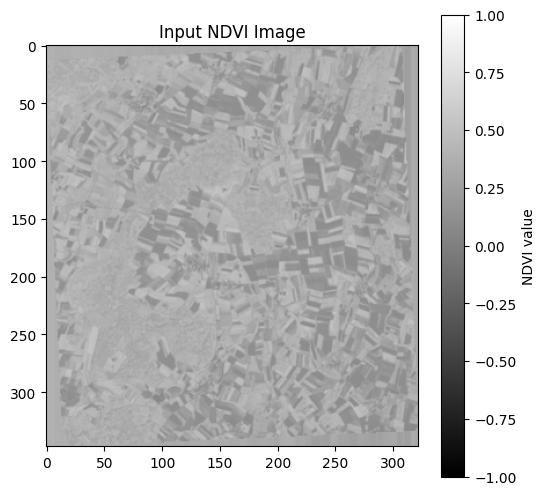

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Si l'image a une 3ᵉ dimension inutile (par ex. (H, W, 1)), on la "squeeze"
if input_img.ndim == 3 and input_img.shape[-1] == 1:
    input_img = np.squeeze(input_img)

# Affichage
plt.figure(figsize=(6, 6))
plt.imshow(input_image, cmap='gray', vmin=-1, vmax=1)
plt.title("Input NDVI Image")
plt.colorbar(label='NDVI value')
plt.axis('on')  # ou 'off' si tu veux retirer les axes
plt.show()
